In [1]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.backend import ctc_decode
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import load_model
from keras.saving import register_keras_serializable
from scipy.ndimage import rotate

In [2]:
@register_keras_serializable(package='Custom', name='CTCLayer')
class CTCLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

# Load the model with the custom CTCLayer
model = load_model('my_model_100.keras', custom_objects={'CTCLayer': CTCLayer})

In [3]:
# List of characters
characters = ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
              '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 
              'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
              'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=characters, mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=characters, mask_token=None, invert=True)

In [4]:
def decode_batch_predictions(pred, max_len):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Perform CTC decoding (greedy search)
    decoded, _ = ctc_decode(pred, input_length=input_len, greedy=True)
    
    # decoded is a list of length 1 containing the actual tensor we need, hence [0]
    decoded = decoded[0][:, :max_len]
    
    output_text = []
    for res in decoded:
        # Convert res to numpy array and flatten
        res = tf.squeeze(res).numpy()

        # Print raw decoded indices for debugging
        print("Raw decoded indices:", res)  
        
        # Remove padding and blank indices (if blank is 0)
        res = res[res != -1]  # Remove -1 padding
        res = res[res != 0]   # Remove blank token if it's indexed as 0
        
        # Print filtered indices for debugging
        print("Filtered indices:", res)  
        
        # Convert indices to characters
        decoded_str = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        
        # Append the decoded string to output_text
        output_text.append(decoded_str)
    
    return output_text


In [5]:
image_width = 128
image_height = 32
img_size=(image_width, image_height)

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
Raw decoded indices: [61 71 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Filtered indices: [61 71]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Raw decoded indices: [16 22 17 18 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Filtered indices: [16 22 17 18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Raw decoded indices: [53 58 57 72 72 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Filtered indices: [53 58 57 72 72]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Raw decoded indices: [53 64 63 53 77 71 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Filtered indices: [53 64 63 53 77 71]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Raw decoded indices: [ 3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Filtered indices: [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Raw decoded indices: [61 57 72 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Filtered indices: [61 57 72]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Raw decoded indices: [61 73 71 61 6

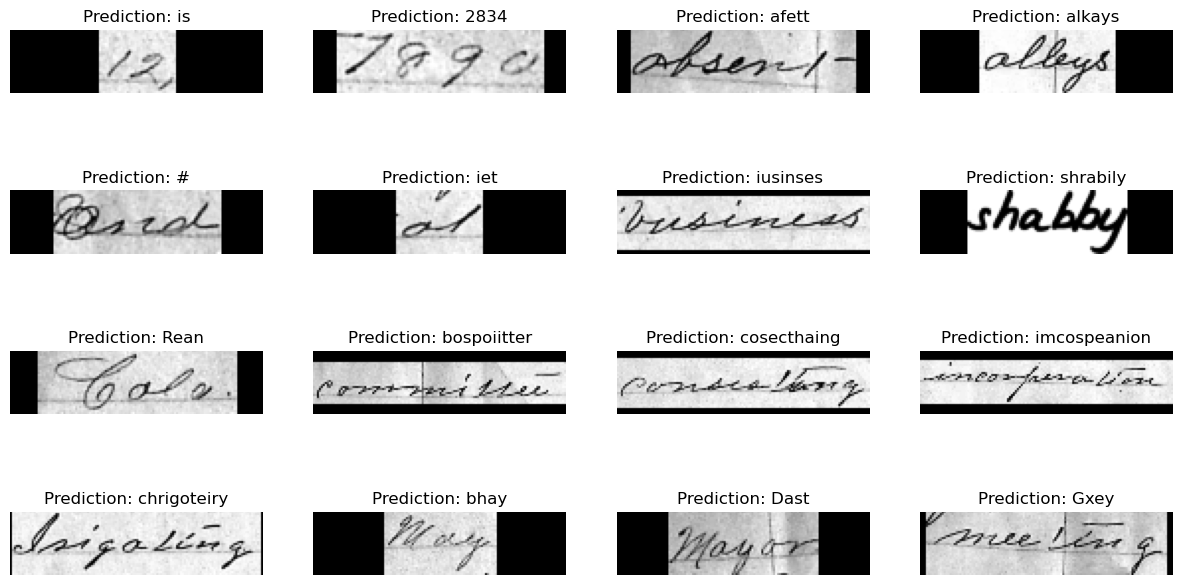

In [6]:
# Folder containing images
image_folder = 'windsor_historical_data/Book_1_images/test_words/s01-000'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Display images and predictions
_, ax = plt.subplots(4, 4, figsize=(15, 8))

for i, image_file in enumerate(image_files[:16]):  # Display up to 16 images
    img_path = os.path.join(image_folder, image_file)
    img = Image.open(img_path) 

    # Enhance the contrast of the image
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(3.0)  # Increase contrast; adjust factor as needed

    # Convert image to grayscale
    img = img.convert('L')

    # Convert the image to a NumPy array for OpenCV operations
    img_array = np.array(img)

    # Apply Gaussian Blur (optional, to remove noise)
    img_array = cv2.GaussianBlur(img_array, (5, 5), 0)

    # Convert back to PIL Image after OpenCV processing
    img = Image.fromarray(img_array)

    # Convert the PIL image to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=-1)  # Add channel dimension
    
    # Apply the distortion-free resize
    img_tensor = distortion_free_resize(img_tensor, img_size=(128, 32))

    # Convert the TensorFlow tensor back to a NumPy array
    img_array = img_tensor.numpy().astype('float32') / 255.0
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)  # Shape should now be (1, 32, 128, 1)

    # Create a dummy label input with the same batch size as img_array
    label_length = 21  # Replace with the correct length for your model
    dummy_labels = np.zeros((1, label_length))  # Create a dummy label input
    
    # Make prediction with both inputs
    preds = model.predict([img_array, dummy_labels])
    pred_texts = decode_batch_predictions(preds, max_len=21)

    # Prepare the image for display by transposing back to the original orientation
    img_disp = img_tensor.numpy()
    img_disp = tf.transpose(img_disp, perm=[2, 0, 1])  # Transpose back for display
    img_disp = img_array[0, :, :, 0] * 255.0
    img_disp = img_disp.astype(np.uint8)

    # Rotate the image by the specified angle
    img_disp = rotate(img_disp, angle=90, reshape=True)
    
    # Display the image and prediction
    ax[i // 4, i % 4].imshow(img_disp,cmap="gray")
    ax[i // 4, i % 4].set_title(f"Prediction: {pred_texts[0]}")
    ax[i // 4, i % 4].axis("off")

plt.show()